In [6]:
from influxdb_client import InfluxDBClient
# This code gathers data from all the fuses, cleans them and then compiles them into one dataset
# Connection settings
username = "homeassistant"
password = "homeassistant"
influx_host = "http://192.168.188.74:8086"
token = f"{username}:{password}"
org = "-" 
database_name = "homeassistantdb"

# Initialize client
client = InfluxDBClient(
    url=influx_host,
    token=token,
    org=org
)

fuse_id = ["03_solarinput63a_active_power",
"ams_linje6_po",
"ams_linje6_p",
"11_varmepumpe32a_apparent_power",
"12_vvbereder3kw16a_active_power",
"u05_billader16a_active_power",
"04_fyrkjelevarmepump_active_power",
"03a_kjokken_3p_230vl_active_power",
"05_kjokkenlys15a_active_power",
"06_kjeller15a_active_power",
"07_lysstikk1floor16a_active_power",
"08_lysstikk2ndfloor1_active_power",
"10badgammel13a_active_power"]



results = []
# Flux query for last 24 hours of data
for fuse in fuse_id:

    fuse_results = []
    
    flux_query = f'''
    from(bucket: "{database_name}/autogen")
      |> range(start: -24h)
      |> filter(fn: (r) => r._measurement == "W" and r._field == "value")
      |> filter(fn: (r) => r.entity_id == "{fuse}")
    '''
    
    print("Start")
    
    try:
        result = client.query_api().query(query=flux_query)
        for table in result:
            for record in table.records:
                fuse_results.append(record)

        results.append(fuse_results)
    
    except Exception as e:
        print("An error occurred:", e)
    
    print("End")




Start
End
Start
End
Start
End
Start
End
Start
End
Start
End
Start
End
Start
End
Start
End
Start
End
Start
End
Start
End
Start
End


In [7]:
import pandas as pd

structured_data = []

# Process each fuse's results
for data in results:
    fuse_structured_data = []

    for record in data:
        field = record['_field']
        value = record['_value']
        measurement = record['_measurement']
        timestamp = record['_time']
        entity_id = record['entity_id']
        domain = record['domain']

        fuse_structured_data.append({
            'field': field,
            'value': value,
            'measurement': measurement,
            'timestamp': timestamp,
            'entity_id': entity_id,
            'domain': domain
        })

    structured_data.append(fuse_structured_data)


flat_structured_data = [record for fuse_data in structured_data for record in fuse_data]
df = pd.DataFrame(flat_structured_data)

# Filter and sort the data
df_cleaned = df[df['value'] != 'power']
df_cleaned = df_cleaned.sort_values(by='timestamp', ascending=True)

df_cleaned.head()




,field,value,measurement,timestamp,entity_id,domain
2104,value,1255.0,W,2024-11-21 13:12:12.137397+00:00,ams_linje6_p,sensor
2105,value,1254.0,W,2024-11-21 13:12:14.652745+00:00,ams_linje6_p,sensor
2106,value,1243.0,W,2024-11-21 13:12:17.155609+00:00,ams_linje6_p,sensor
2107,value,1244.0,W,2024-11-21 13:12:20.683914+00:00,ams_linje6_p,sensor
2108,value,1243.0,W,2024-11-21 13:12:24.630962+00:00,ams_linje6_p,sensor


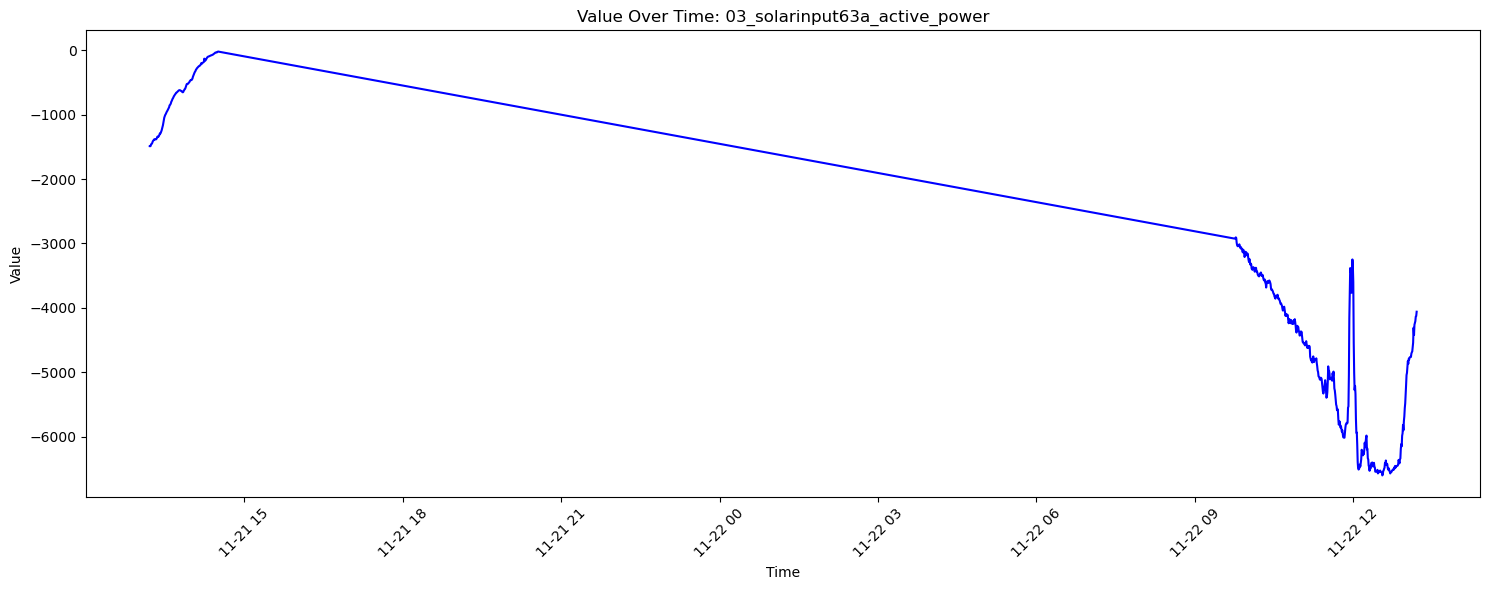

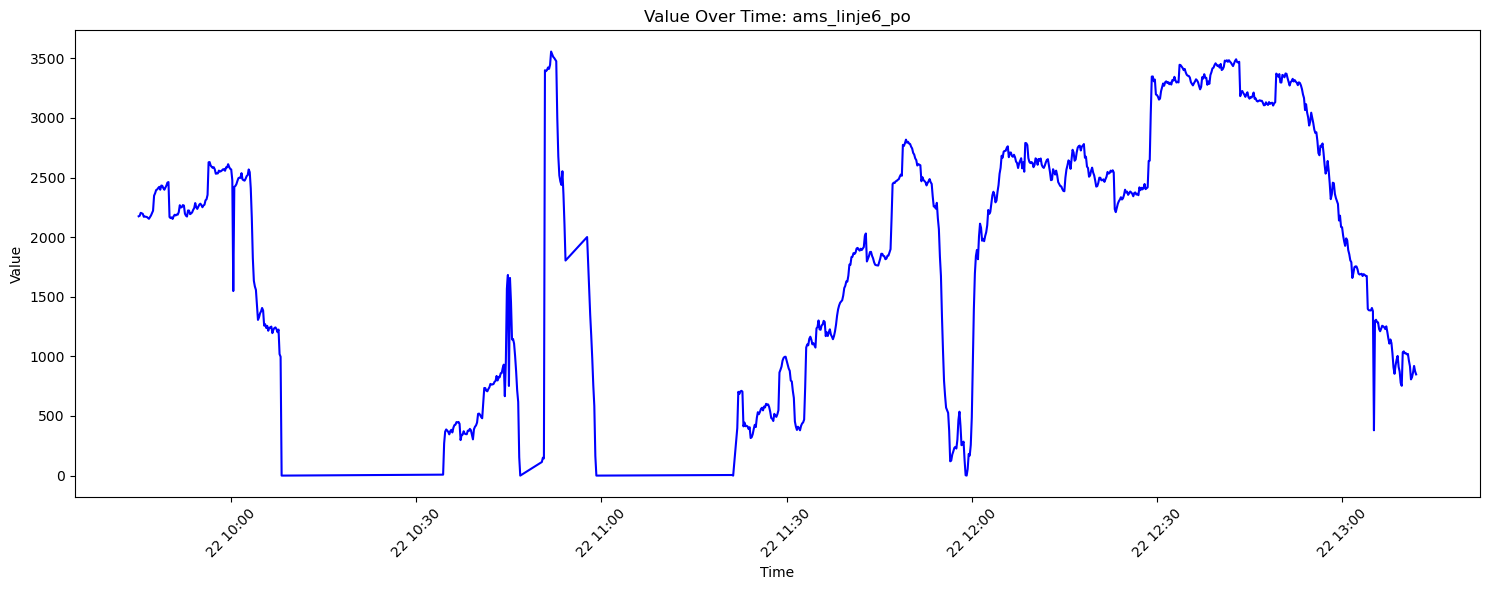

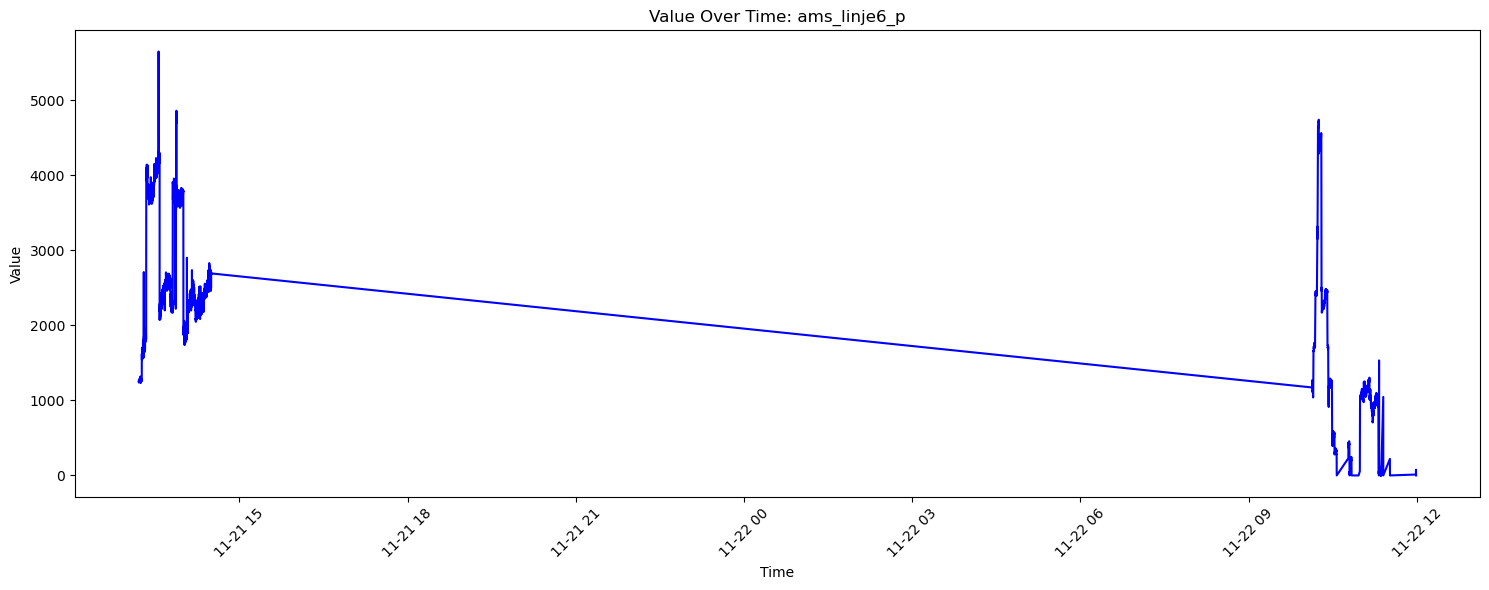

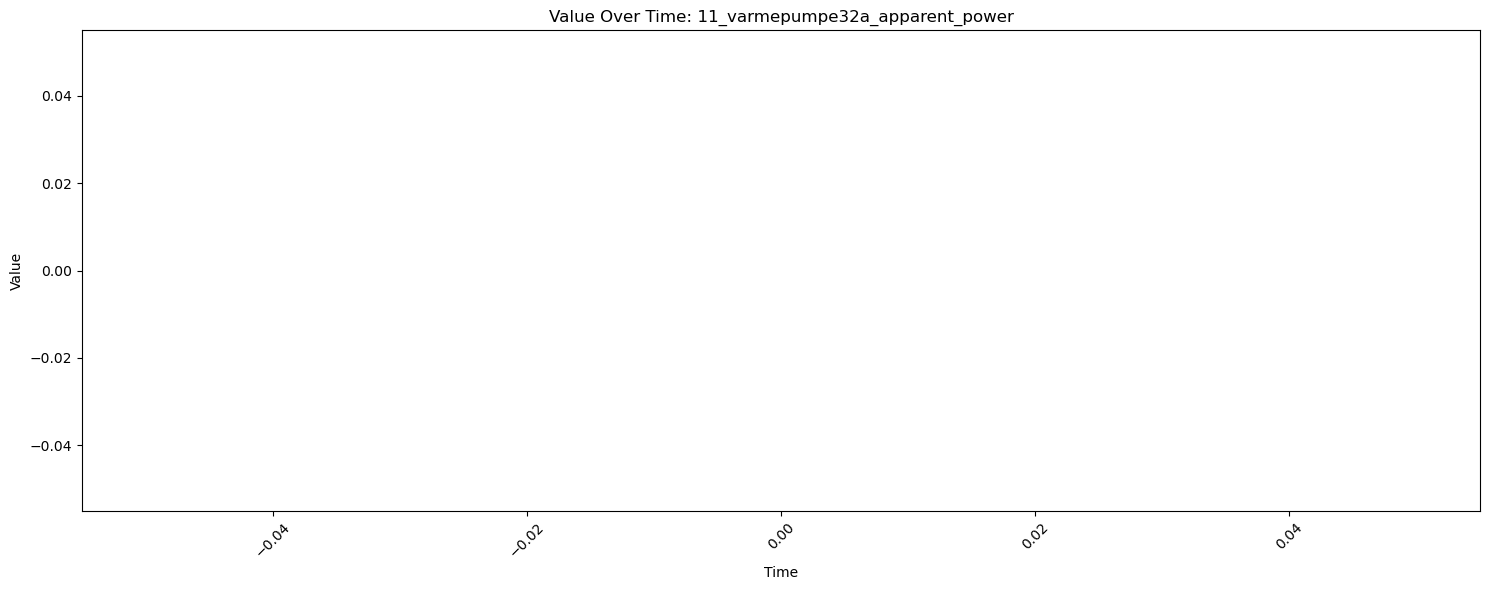

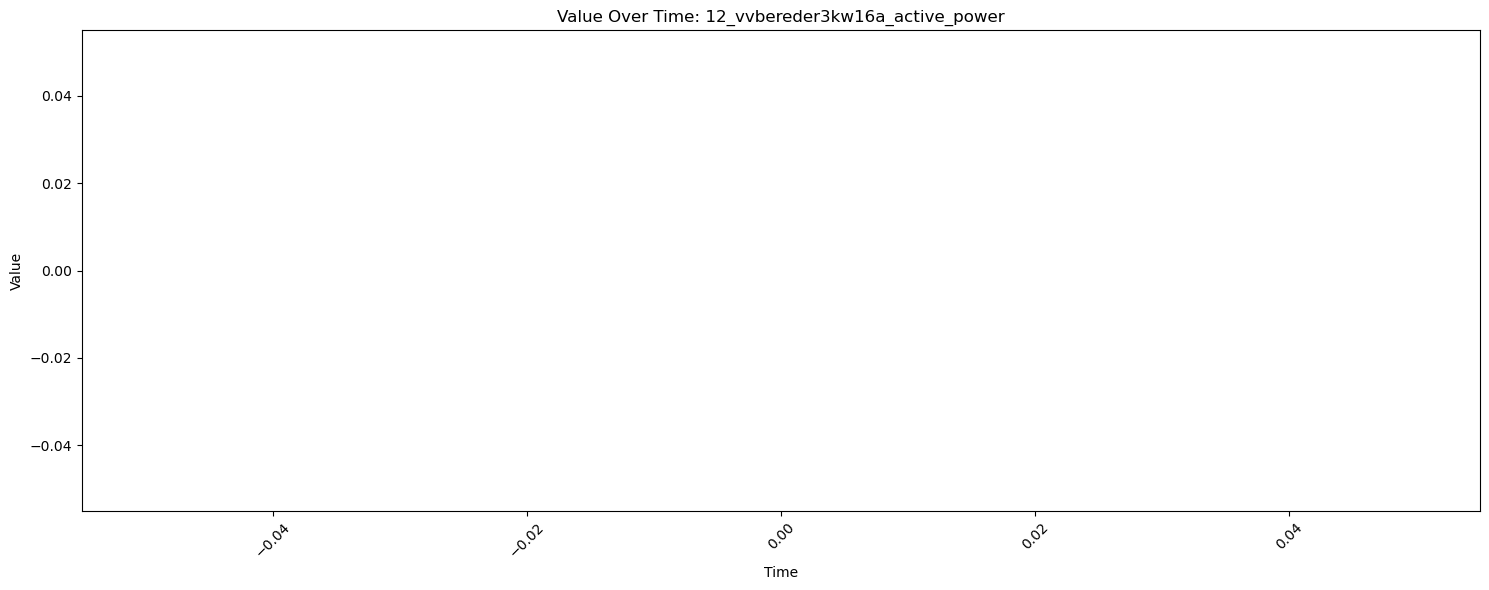

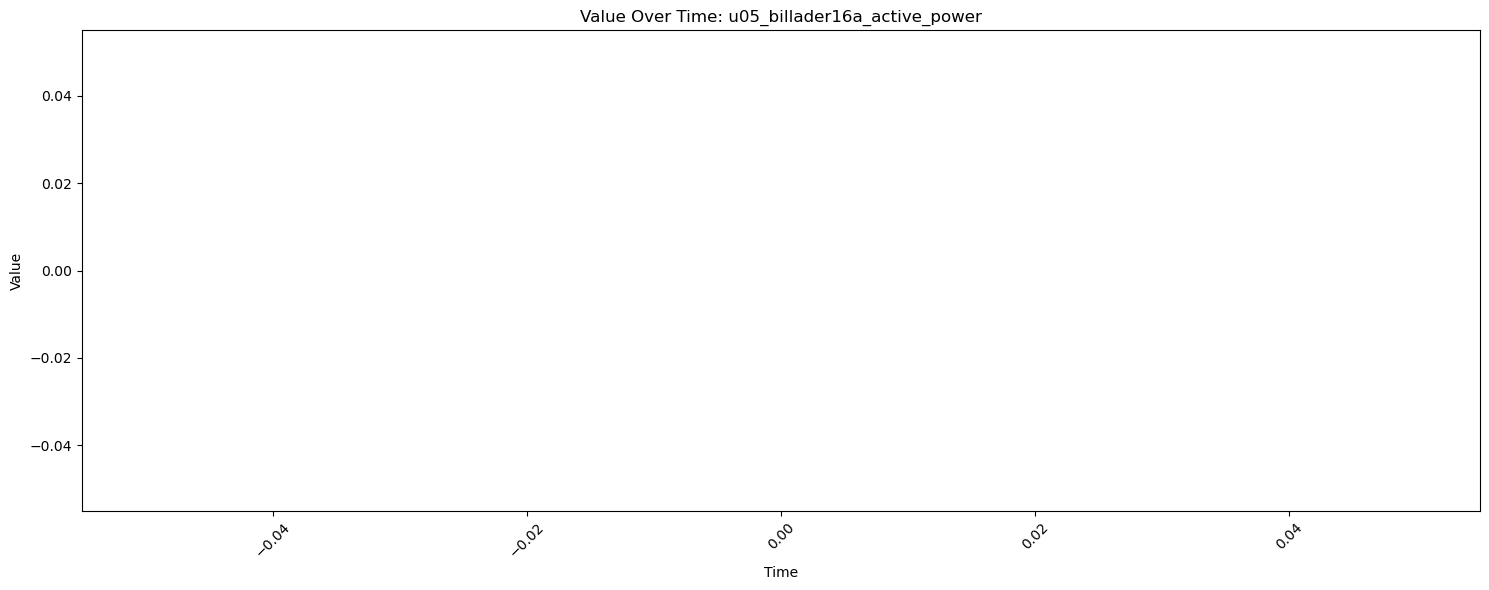

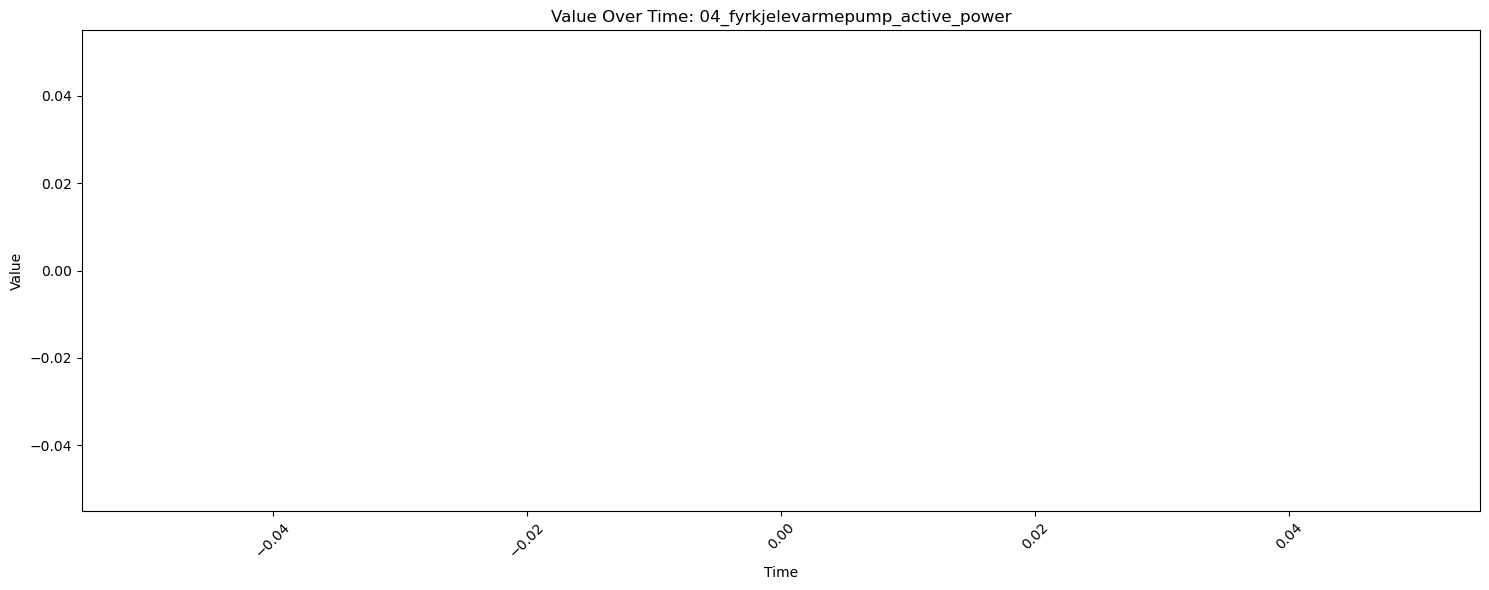

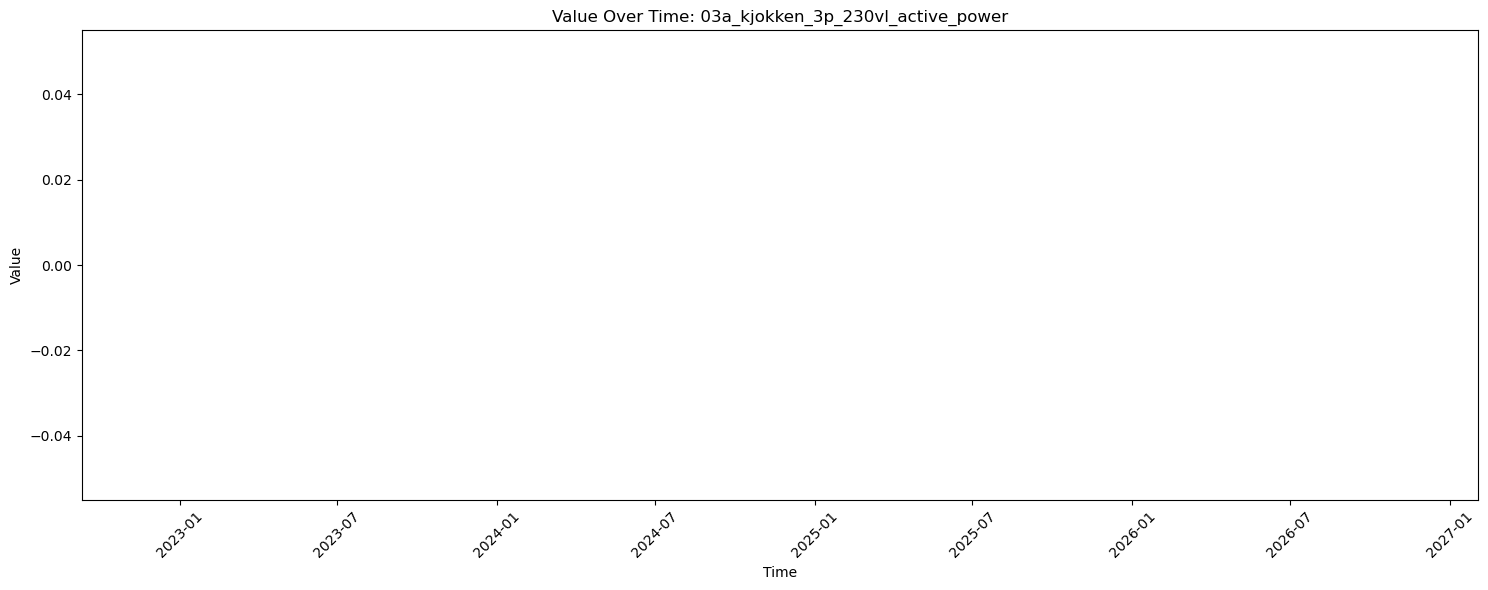

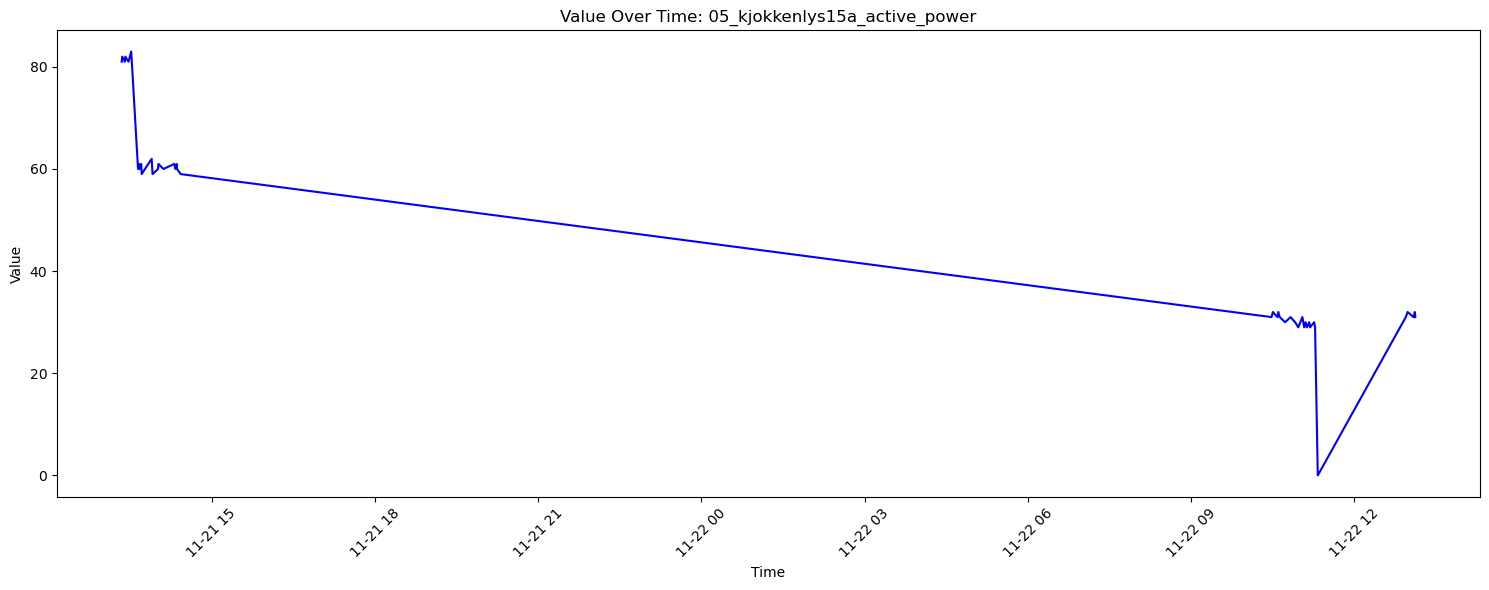

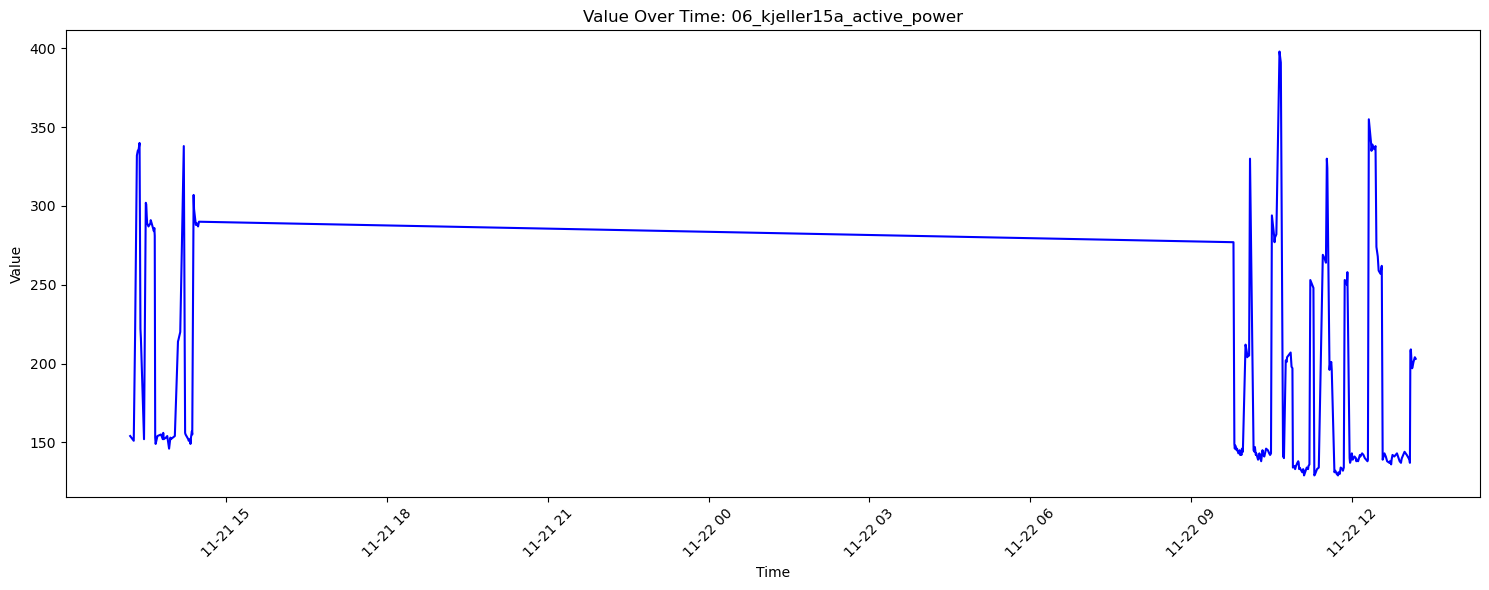

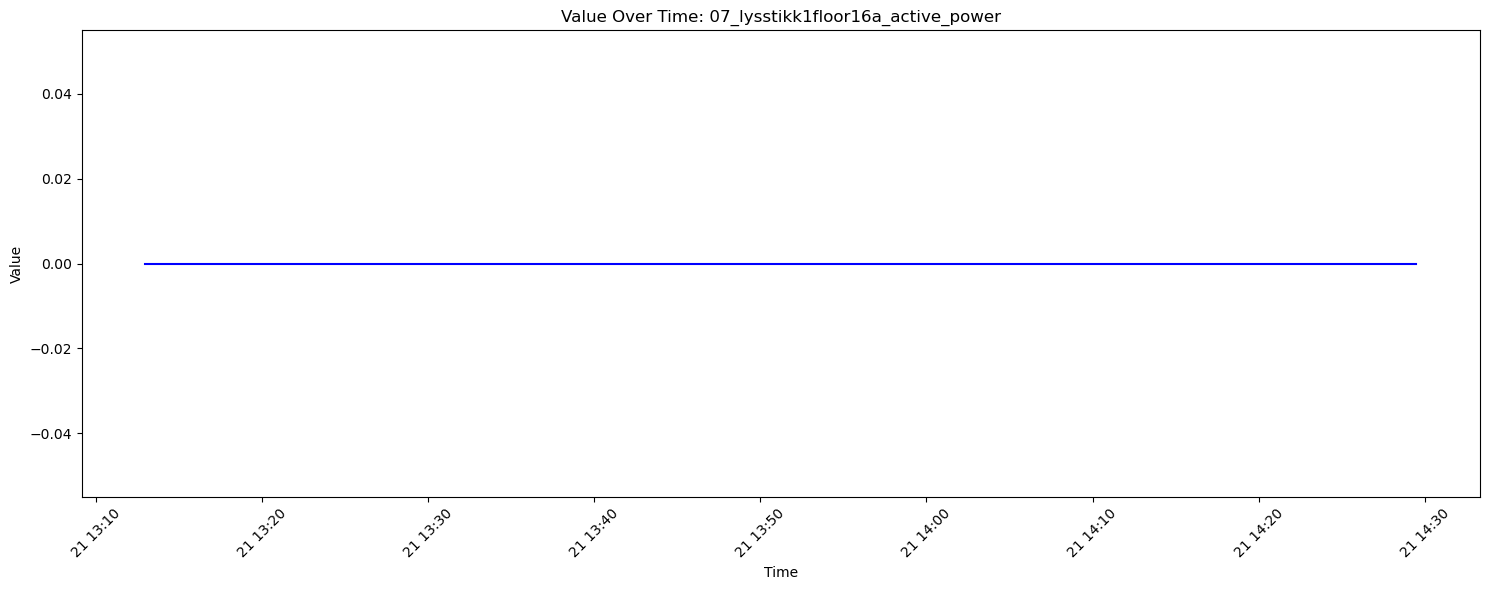

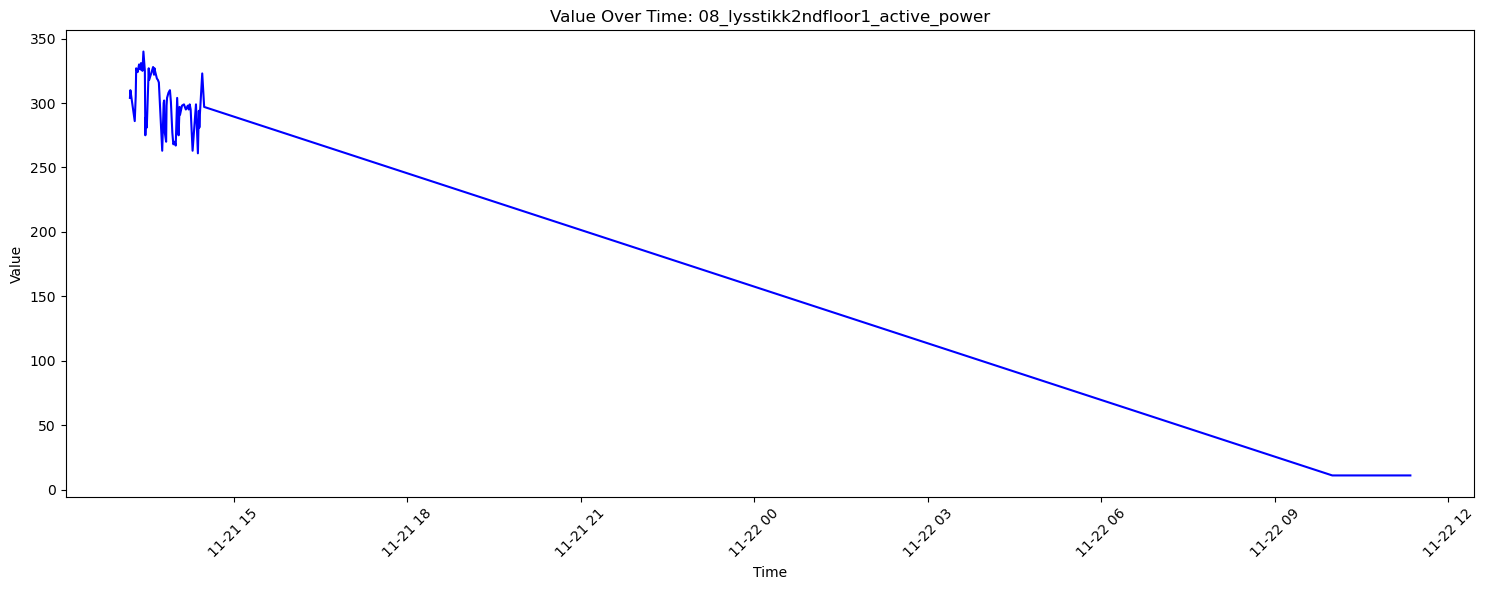

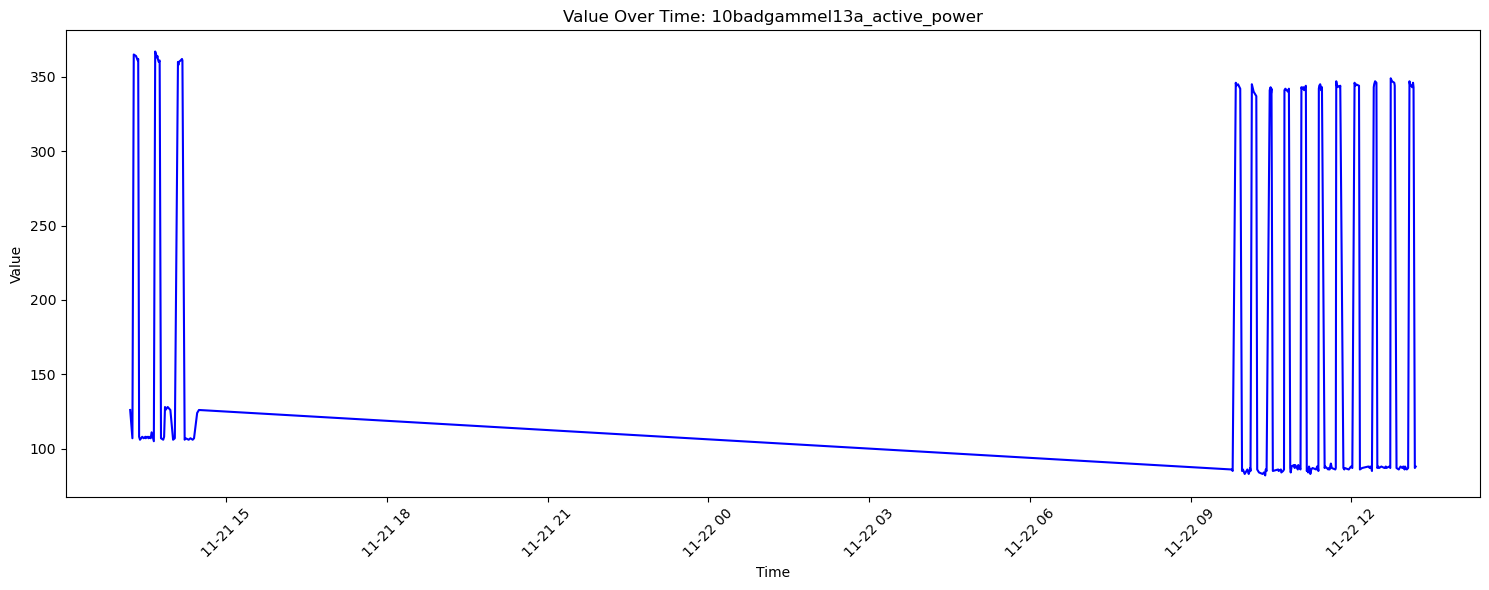

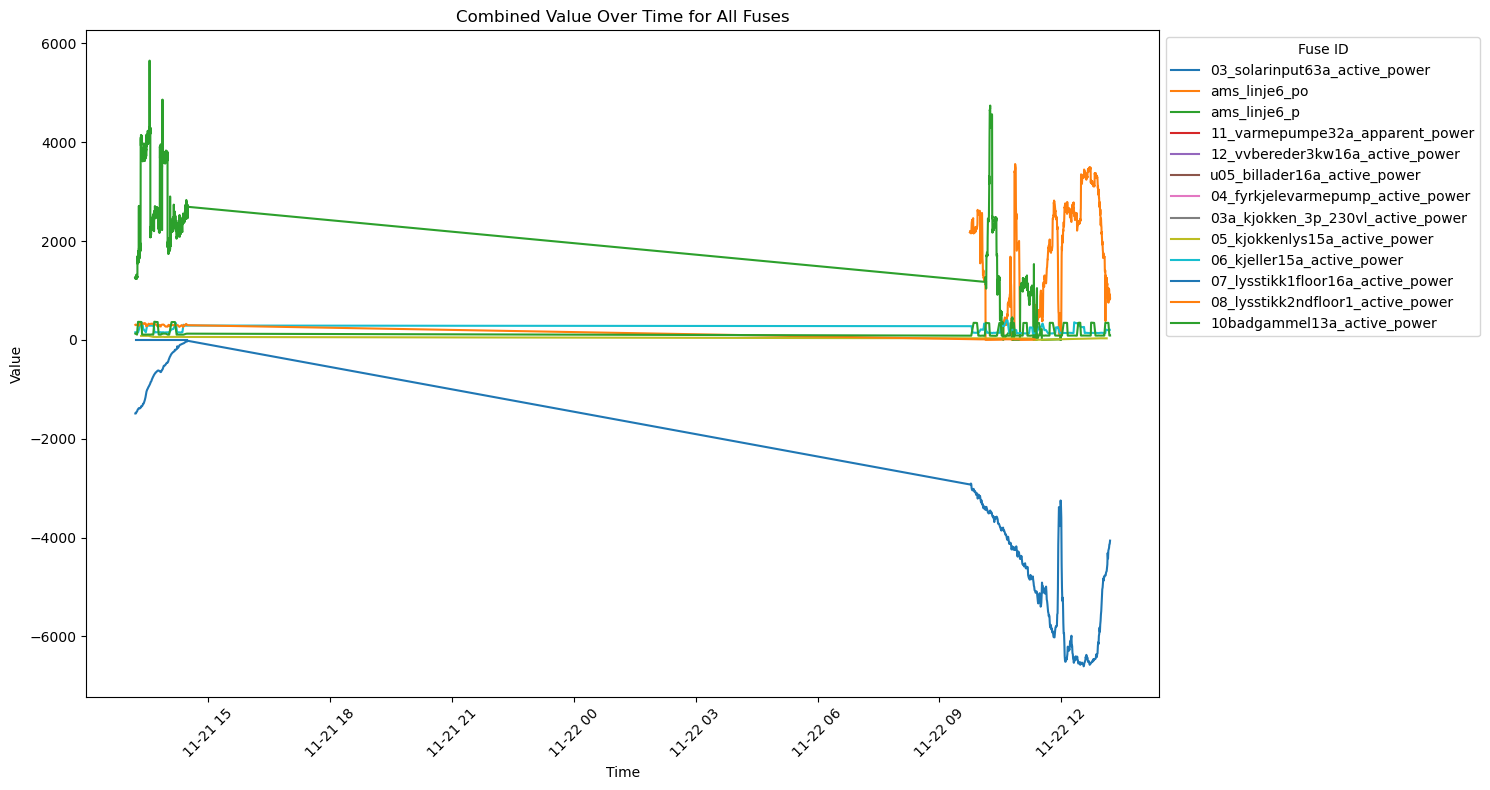

In [9]:
import matplotlib.pyplot as plt


# Ensure 'value' column is numeric, convert if necessary
df_cleaned['value'] = pd.to_numeric(df_cleaned['value'], errors='coerce')
# Drop any rows where 'value' could not be converted (if any)
df_cleaned = df_cleaned.dropna(subset=['value'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

#Export all data to a compiled dataset
df_filtered.to_csv('Data_Signatures_Grid.csv')

# Plot the data
for fuse in fuse_id:
    
    fuse_data = df_filtered[df_filtered['entity_id'] == fuse]
    
    plt.figure(figsize=(15, 6))
    plt.plot(fuse_data['timestamp'], fuse_data['value'], marker='', linestyle='-', color='b')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Value Over Time: {fuse}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
plt.figure(figsize=(15, 8))

for fuse in fuse_id:
    fuse_data = df_filtered[df_filtered['entity_id'] == fuse]
    plt.plot(fuse_data['timestamp'], fuse_data['value'], label=fuse, marker='', linestyle='-')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Combined Value Over Time for All Fuses')
plt.xticks(rotation=45)
plt.legend(title='Fuse ID', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
